In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders import TargetEncoder
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, root_mean_squared_error, r2_score
from joblib import dump, load

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Area under ROC score on Train dataset: 0.93


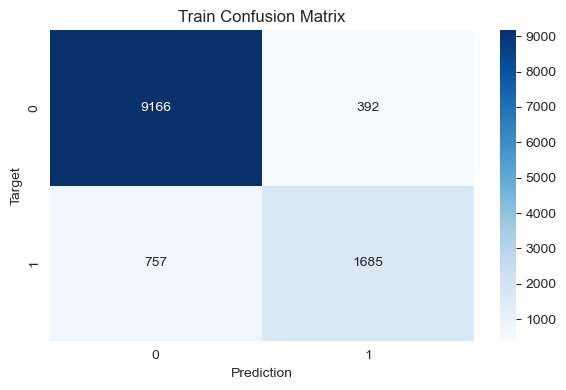

Area under ROC score on Validation dataset: 0.93


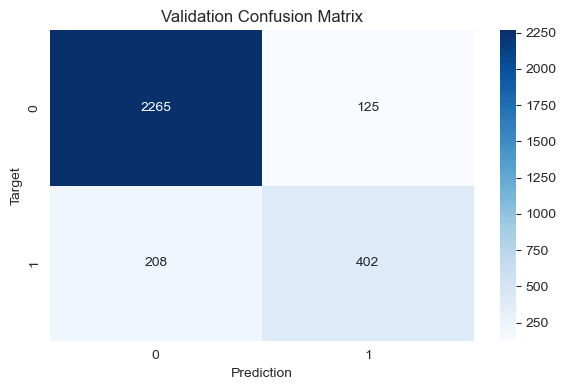

['../assets/hw_2_2/log_reg.joblib']

In [3]:
set_config(transform_output='pandas')
raw_df = pd.read_csv('../assets/hw_2_2/train.csv', index_col=0)

train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df["Exited"])

# Створюємо трен. і вал. набори
target_col = 'Exited'

drop_cols = ['id', 'CustomerId', target_col]
input_cols = [col for col in train_df.columns if col not in drop_cols]

train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = ['CreditScore', 'Balance', 'EstimatedSalary', 'Tenure']
active_cr_card_cols = ['IsActiveMember', 'HasCrCard']
tenure_age_cols = ['Age', 'Tenure']
categorical_cols = ['Geography', 'Gender', 'NumOfProducts']
target_encoded_cols = ['Surname', 'NumOfProducts', 'Gender', 'Geography']

# Створюємо трансформери для числових і категоріальних колонок
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
])

categorical_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')),
])

target_enc_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', TargetEncoder()),
])


def ActiveCrCardFunc(d):
    d['ActiveCrCard'] = d['HasCrCard'] + (4 * d['IsActiveMember']) + 1
    return d[['ActiveCrCard']]


def TenurebyAgeFunc(d):
    d['Age'] = np.log(d['Age'])
    d['TenureAgeRatio'] = d['Tenure'] / d['Age']
    return d[['TenureAgeRatio']]


ActiveCrCard_pipeline = make_pipeline(
    num_pipeline,
    FunctionTransformer(ActiveCrCardFunc, validate=False),
)
TenureAge_pipeline = make_pipeline(
    num_pipeline,
    FunctionTransformer(TenurebyAgeFunc, validate=False),
)
Age_pipeline = make_pipeline(
    num_pipeline,
    FunctionTransformer(func=np.log, validate=False),
)

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessing = ColumnTransformer([
    ('N', num_pipeline, numeric_cols),
    ('ActiveCrCard', ActiveCrCard_pipeline, active_cr_card_cols),
    ('TenureAgeR', TenureAge_pipeline, tenure_age_cols),
    ('Age', Age_pipeline, [tenure_age_cols[0]]),
    ('Cat', categorical_transformer, categorical_cols),
    ('Tar', target_enc_pipeline, target_encoded_cols),
], remainder='drop', verbose_feature_names_out=False)

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessing),
    ('scaling', StandardScaler()),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)


# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    probs = model_pipeline.predict_proba(inputs)[:, 1]

    roc_auc = roc_auc_score(targets, probs)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}")

    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix_, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title(f'{name} Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return preds


# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Train')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

# Зберігаємо модель для подальшого використання
save_dir = "../assets/hw_2_2"
dump(model_pipeline, save_dir + "/log_reg.joblib")


**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Train dataset: 0.94


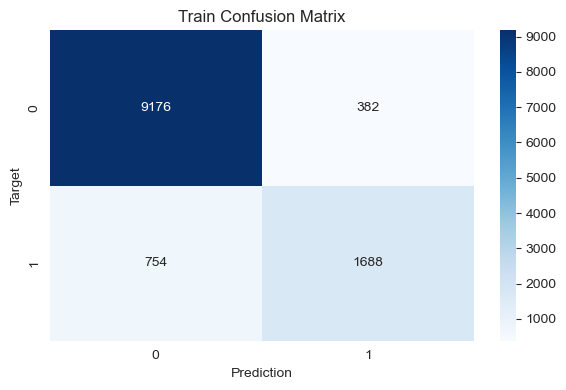

Area under ROC score on Validation dataset: 0.93


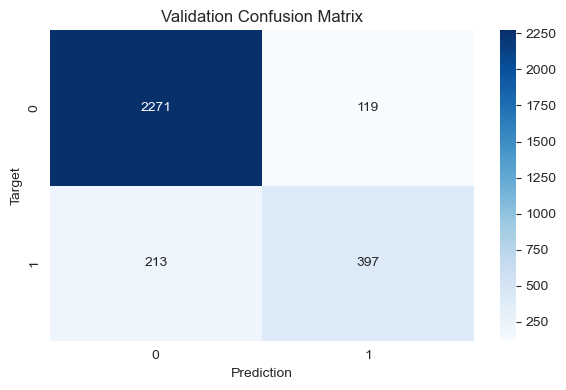

In [4]:
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessing),
    ('scaling', StandardScaler()),
    ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

model_pipeline_poly.fit(train_inputs, train_targets)

train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, name='Train')
val_preds_poly = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, name='Validation')

### Summary: Impact of Adding Polynomial Features (Degree 2)

After adding polynomial features to the preprocessing pipeline, the model's performance shows only a marginal improvement in training metrics:

- **Train AUROC:**
  - Before: 0.93
  - After: **0.94**

- **Validation AUROC:**
  - Before: 0.93
  - After: **0.93** (no change)

- **Train Confusion Matrix:**
  - Slight improvement in true positives (from 1685 → 1688)
  - Slight reduction in false positives (from 392 → 382)

- **Validation Confusion Matrix:**
  - Negligible differences (402 → 397 true positives, 125 → 119 false positives)

### Conclusion:
- The model with polynomial features **does not show signs of overfitting**, since AUROC and confusion matrix values on validation set remained stable.
- The slight improvement in training metrics suggests **a minor benefit from added feature interactions**, but **generalization did not improve**.
- This implies that the original model was already well-regularized and adding complexity gave **diminishing returns**.

The model still generalizes well, and the addition of polynomial features is safe but **not significantly beneficial**.


**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Train dataset: 0.94


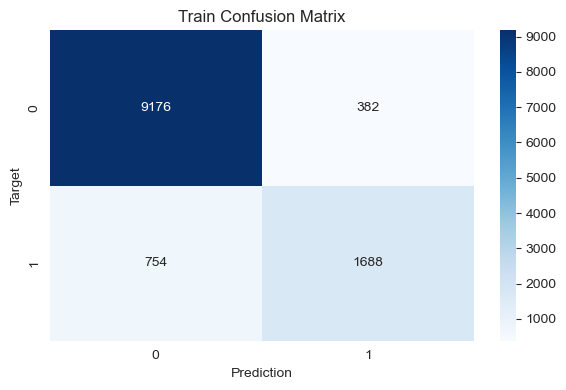

Area under ROC score on Validation dataset: 0.93


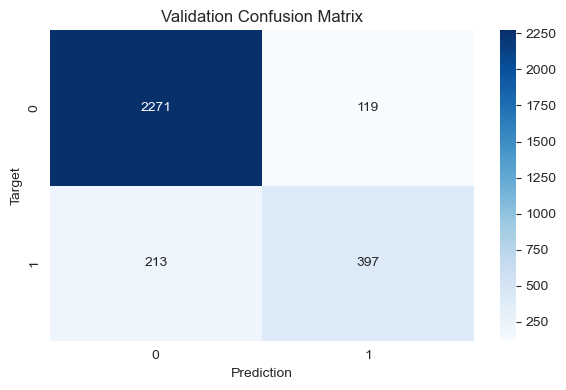

In [5]:
model_pipeline_poly_4 = Pipeline(steps=[
    ('preprocessor', preprocessing),
    ('scaling', StandardScaler()),
    ('polynomial', PolynomialFeatures(degree=4, include_bias=False)),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, max_iter=5000))
])

model_pipeline_poly_4.fit(train_inputs, train_targets)

train_preds_poly_4 = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, name='Train')
val_preds_poly_4 = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, name='Validation')

## Summary: Impact of Polynomial Features on Model Performance

### Without Polynomial Features:
- **Train ROC AUC**: 0.93
- **Validation ROC AUC**: 0.93
- **Train Confusion Matrix**:
  - TP: 1685, TN: 9166, FP: 392, FN: 757
- **Validation Confusion Matrix**:
  - TP: 402, TN: 2265, FP: 125, FN: 208

### With Polynomial Features (degree = 2):
- **Train ROC AUC**: 0.94
- **Validation ROC AUC**: 0.93
- **Train Confusion Matrix**:
  - TP: 1688, TN: 9176, FP: 382, FN: 754
- **Validation Confusion Matrix**:
  - TP: 397, TN: 2271, FP: 119, FN: 213

### With Polynomial Features (degree = 4):
- **Train ROC AUC**: 0.94
- **Validation ROC AUC**: 0.93
- **Training Time**: ~4 minutes (vs 2 seconds for degree 2)

### Conclusion:
- Adding polynomial features up to degree 2 slightly improved the training ROC AUC (0.93 → 0.94), while the validation ROC AUC remained constant (0.93), suggesting **no overfitting** and **stable generalization**.
- Degree 4 polynomial features did not improve performance but increased computation time, indicating **diminishing returns** and unnecessary complexity.
- Final verdict: **Polynomial features of degree 2 are acceptable**, but **higher degrees bring more cost than benefit** for this task.


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [6]:
raw_df_new = pd.read_csv('../assets/hw_2_2/regression_data.csv', index_col=0)

raw_df_new.head()

,feature_2,feature_3,feature_4,feature_5,target
feature_1,,,,,
-0.190339,-1.382800,-0.875618,0.538910,-1.037246,28.938854
-0.321386,-0.563725,0.412931,-0.147057,-0.825497,-7.664581
2.122156,-1.519370,1.032465,-1.260884,0.917862,-63.845482
-1.380101,-0.055548,-1.703382,0.074095,1.628616,4.076259
-0.072829,-1.514847,-0.846794,0.714000,0.473238,34.879013


In [7]:
X = raw_df_new.drop(columns='target')
y = raw_df_new['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_rmse = root_mean_squared_error(y_train, y_train_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {train_rmse:.2f}, R2: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")

Train RMSE: 0.00, R2: 1.00
Test RMSE: 38.38, R2: 0.37


## Summary

A linear regression model was trained using numerical features scaled and extended with polynomial features up to degree **5**.

**Evaluation Metrics:**
- **Train RMSE:** 0.00
- **Train R²:** 1.00
- **Test RMSE:** 38.38
- **Test R²:** 0.37

**Conclusion:**
The model shows clear signs of **overfitting**. While it performs perfectly on the training data, its performance on the test set significantly drops. This indicates poor generalization — the model memorizes the training data rather than learning meaningful patterns.


**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [11]:
def build_pipeline(model):
    return Pipeline([
        ('scale', StandardScaler()),
        ('poly', PolynomialFeatures(degree=10, include_bias=False)),
        ('reg', model)
    ])

def get_top_features(pipe, input_features, top_n=10):
    poly = pipe.named_steps['poly']
    reg = pipe.named_steps['reg']
    feature_names = poly.get_feature_names_out(input_features)
    coefs = reg.coef_

    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs,
        'abs_coef': np.abs(coefs)
    })
    return coef_df.sort_values(by='abs_coef', ascending=False).head(top_n)[['feature', 'coefficient']]


models = {
    "Lasso": Lasso(alpha=0.01, max_iter=1_000_000),
    "Ridge": Ridge(alpha=1.0),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=1_000_000)
}

models_new_params = {
    "Ridge_new": Ridge(alpha=1e5),
    "ElasticNet_new": ElasticNet(alpha=1.0, l1_ratio=0.7, max_iter=1_000_000)
}

all_models = {**models, **models_new_params}

results = {}
top_features_dict = {}

for name, model in all_models.items():
    pipe = build_pipeline(model)
    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    results[name] = {
        "Train RMSE": root_mean_squared_error(y_train, y_pred_train),
        "Test RMSE": root_mean_squared_error(y_test, y_pred_test),
        "Train R2": r2_score(y_train, y_pred_train),
        "Test R2": r2_score(y_test, y_pred_test)
    }

    poly = pipe.named_steps['poly']
    reg = pipe.named_steps['reg']
    feature_names = poly.get_feature_names_out(X_train.columns)
    coefs = reg.coef_

    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefs,
        'abs_coef': np.abs(coefs)
    })
    top_features = coef_df.sort_values(by='abs_coef', ascending=False).head(10)[['feature', 'coefficient']]

    top_features_dict[name] = top_features

metrics_df = pd.DataFrame(results).T
print("\nMetrics summary:\n")
print(metrics_df)

for name, top_df in top_features_dict.items():
    print(f"\nTop features for {name}:\n", top_df)


C:\Users\Dmity\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.030e+01, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Dmity\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.584e+02, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(



Metrics summary:

                Train RMSE    Test RMSE  Train R2      Test R2
Lasso             0.454324    17.765704  0.999894     0.864719
Ridge             1.209851  2331.306211  0.999249 -2328.548247
ElasticNet        0.841126   687.132104  0.999637  -201.373456
Ridge_new        26.497738   172.893495  0.639532   -11.812397
ElasticNet_new    9.039355    65.293799  0.958051    -0.827330

Top features for Lasso:
                    feature  coefficient
2                feature_4    43.507565
26   feature_3^2 feature_5     1.262011
30             feature_4^3     0.699940
18   feature_2 feature_3^2    -0.520914
180  feature_2 feature_5^5    -0.391306
69             feature_2^5     0.362585
5      feature_2 feature_3    -0.293044
212  feature_2^6 feature_5    -0.273123
8              feature_3^2     0.257456
12     feature_4 feature_5    -0.252395

Top features for Ridge:
                      feature  coefficient
2                  feature_4    23.312057
30               feature_4^

C:\Users\Dmity\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.624e+02, tolerance: 2.006e+01
  model = cd_fast.enet_coordinate_descent(


### Summary

In this experiment, we significantly increased the number of polynomial features up to degree 20 to test the models' ability to handle extreme feature expansion and investigate potential overfitting. This approach was used intentionally to explore the limits of model regularization and understand how the models generalize, taking into account computational resources (training time increased substantially).

#### Metrics summary

|              | Train RMSE | Test RMSE | Train R2 | Test R2    |
|--------------|-------------|-----------|----------|------------|
| Lasso        | 0.45       | 17.77    | 0.9999  | 0.86     |
| Ridge        | 1.21       | 2331.31  | 0.9992  | -2328.55 |
| ElasticNet   | 0.84       | 687.13   | 0.9996  | -201.37  |
| Ridge_new    | 26.50      | 172.89   | 0.64    | -11.81  |
| ElasticNet_new | 9.04     | 65.29    | 0.96    | -0.83   |

#### Analysis

- **Lasso** performed best in terms of generalization to the test set, even with a very high number of polynomial features. It effectively zeroed out many coefficients, preventing overfitting.
- **Ridge** and **ElasticNet** (original parameters) exhibited extreme overfitting: very low training error but huge test error.
- In the updated versions (**Ridge_new**, **ElasticNet_new**), we increased the regularization strength (alpha = 1000), which reduced overfitting slightly but still led to weak test performance. This indicates that simply increasing regularization is not always sufficient to control overfitting when feature space explodes exponentially.
- The number of polynomial features reached over 10,000, creating a heavy computational load (several minutes to train), which illustrates practical limitations of such approaches.

#### Top features comparison

The top features selected by each model show how each regularization method prioritized different interactions. For example, Lasso mostly selected simple terms involving `feature_4`, while Ridge and ElasticNet included very complex high-degree combinations, particularly in their original versions.

---

**Conclusion**

- Lasso remains the most robust choice when extreme polynomial expansion is used, thanks to its ability to sparsify coefficients.
- Stronger regularization in Ridge and ElasticNet helped partially but did not fully solve the overfitting problem.
- This experiment highlights the importance of carefully controlling feature engineering and regularization strength, especially when using high-degree polynomial features.

